In [1]:
import re
from unicodedata import normalize
from string import punctuation
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
# from pyclustering.cluster.xmeans import xmeans, kmeans
# from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [2]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = NLP(re.sub(r'["\'@#%\(\)]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
                clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
    return clean_frase

def _get_stopwords():
    stpwords = stopwords.words('portuguese') + list(punctuation)
    rms = ['um', 'não', 'mais', 'muito']
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7), (244, 188, 198)
]).astype(np.float32)

colors /= 255.0

### Carregamento dos datasets

Os datasets de exemplos são frases já pré-categorizadas usadas em chatbots.

Contém 33 categorias e ao todo 696 documentos ou frases.

In [3]:
df_data1 = pd.read_csv("intents.csv", sep=';', names=["cluster", "perguntas"])
df_data2 = pd.read_csv("ground_truth.csv", sep=';', names=["perguntas", "cluster"])

df_data1 = df_data1[df_data1.columns[::-1]]
df_data = pd.concat([df_data1, df_data2], sort=False)
df_data.dropna(inplace=True)
df_data['cluster'] = df_data['cluster'].str.upper()

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(df_data.iloc[index].sort_values(by=["cluster"]))

c = np.argmax(pd.get_dummies(df_data["cluster"]).to_numpy(), axis=1)

N = df_data["cluster"].to_numpy().shape[0]
clusters = len(set(c))

,perguntas,cluster
250,como solicitar um novo certificado digital para um sistema que criei no me departamento?,CERTIFICADO
212,esta dando erro ao tentar criar meu novo username,CONTA
234,"estou tentanto criar meu username, mas não estou conseguindo",CONTA
77,obrigado mesmo,OBRIGADO
13,Como posso registrar um cartão SIM?,TELCO_ACTIVATE_DEVICE
70,"Fui assaltado, preciso acionar seguro.",TELCO_ADD_INSURANCE
179,Por favor me diga quando eu vou ser elegível para minha próxima atualização do dispositivo.,TELCO_DEVICE_UPGRADE_ELIGIBILITY
223,"Eu não sei porque, mas o meu telefone não funciona em casa.",TELCO_NETWORK_COMPLAINTS
253,Eu tenho um cartão SIM no meu aparelho e eu gostaria de desbloqueá-lo.,TELCO_NETWORK_UNLOCK
261,Posso levar meu telefone comigo se eu mudar para uma nova empresa.,TELCO_PORT_IN


In [4]:
uniq, cnt = np.unique(np.asarray(df_data["cluster"]), return_counts=True)
df_org = pd.DataFrame(np.array(list(zip(uniq, cnt))), columns=["Categoria", "Qtde"])

print("Qtde. de documentos por categoria:")
display(df_org.sort_values(by=["Categoria"]))

Qtde. de documentos por categoria:


,Categoria,Qtde
0,ACESSO_REMOTO,20
1,CERTIFICADO,18
2,CONTA,29
3,DUVIDAS,17
4,EMAIL,40
5,LINGUAJAR,24
6,NENHUMA_OPCAO,20
7,NOME_BOT,16
8,OBRIGADO,23
9,SENHAS,27


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_data["perguntas"], c, test_size=0.2)

qtde_docs = len(df_data["perguntas"])
qtde_categ = len(df_data["cluster"])
print(f"Total docs     : {qtde_docs}")
print(f"Total cluster  : {qtde_categ}")
print(f"X_train size   : {X_train.shape}")
print(f"X_test  size   : {X_test.shape}")

Total docs     : 696
Total cluster  : 696
X_train size   : (556,)
X_test  size   : (140,)


### Dataset tokenization

In [6]:
P = X_train.shape[0]
print("Tokenization...")
documents_d2c = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(X_train)]
documents_tfidf = [" ".join(tokenizer(doc)) for doc in X_train]
print("Qtd documentos treino: ", len(documents_d2c))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  556
Qtd Intents treino   :  33
Finished...


In [7]:
documents_d2c[:10]

[TaggedDocument(words=['quer', 'mud', 'servic', 'um', 'nov', 'disposit', 'mant', 'mesm', 'dar', 'pessoal', 'pod', 'diz', 'faze-l'], tags=[0]),
 TaggedDocument(words=['qual', 'outr', 'servic', 'bot', 'oferec'], tags=[1]),
 TaggedDocument(words=['um', 'nom'], tags=[2]),
 TaggedDocument(words=['possivel', 'algu', 'acompanh', 'atrav', 'etap', 'ativ', 'disposit', 'pre-pag'], tags=[3]),
 TaggedDocument(words=['precis', 'faz', 'ativ', 'nov', 'telefon', 'pre-pag', 'remov', 'restrica'], tags=[4]),
 TaggedDocument(words=['nao', 'consegu', 'inic', 'bluetooth', 'emparelh', 'fon', 'ouv', 'dev', 'faz'], tags=[5]),
 TaggedDocument(words=['nenhum', 'opca', 'quer', 'faz'], tags=[6]),
 TaggedDocument(words=['nao', 'precis', 'mais', 'nad', 'obrig'], tags=[7]),
 TaggedDocument(words=['foi-m', 'promet', 'cobertur', 'total', 'cidad', 'inscrev', 'ano', 'pass', 'mes', 'dois', 'cidad', 'nao', 'conexa', 'consert'], tags=[8]),
 TaggedDocument(words=['acess', 'remot', 'sistem', 'empres', 'cas'], tags=[9])]

### **Doc2Vec**

Parâmetros iniciais... quantidade de dimensões dos vetores gerados para cada frase, épocas de treinamento e épocas de posterior inferência para novas frases.

A quantidade de épocas de inferência, sugere-se ser bem superior as de treinamento.

In [8]:
dim = 1000
epochs = 100
M = 12000

print(f"Dimensions   : {dim}")
print(f"Epochs       : {epochs}")
print(f"Infer Epochs : {M}")

Dimensions   : 1000
Epochs       : 100
Infer Epochs : 12000


In [9]:
print("Starting model...")
common_kwargs = dict(
    dm=0, vector_size=dim, epochs=epochs, workers=4, 
    window=10, min_count=2, alpha=1e-2, min_alpha=1e-4,
    hs=1, negative=7, dbow_words=1, sample=0
)
d2v = Doc2Vec(**common_kwargs)
print("Building vocab...")
d2v.build_vocab(documents_d2c)
print("Training...")
d2v.train(
    documents_d2c,
    total_examples=d2v.corpus_count,
    epochs=d2v.epochs
)
print("Finish...")

Starting model...
Building vocab...
Training...
Finish...


Validação do modelo gerado pelo Doc2Vec... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

In [10]:
dc = np.c_[X_train, y_train]

acc = []
for i, xt in enumerate(utils.shuffle([doc for doc in dc])[:75]):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = d2v.docvecs.most_similar(positive=[new_doc_vec], topn=1)
    acc.append(xt[1] == y_train[sim[0][0]])
print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))
print("-" * 20)

dc = np.c_[X_test, y_test]
accc = []
for p in range(5):
    acc = []
    for i, xt in enumerate(utils.shuffle([doc for doc in dc])[:75]):
        new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
        sim = np.array(d2v.docvecs.most_similar(positive=[new_doc_vec], topn=30))
        unq, cnt = np.unique(y_train[sim[:, 0].astype(np.int32)], return_counts=True)
        if unq[np.where(cnt == np.max(cnt))[0][0]] == y_train[sim[0][0].astype(np.int32)]:
            acc.append(xt[1] == y_train[sim[0][0].astype(np.int32)])
        else:
            acc.append(xt[1] == unq[np.where(cnt == np.max(cnt))[0][0]])
    print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
    accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 98.67
--------------------
 - Acurácia teste 1  : 60.0
 - Acurácia teste 2  : 53.33
 - Acurácia teste 3  : 62.67
 - Acurácia teste 4  : 54.67
 - Acurácia teste 5  : 58.67
- Acurácia média teste: 57.87


### Clusterização

Utilizou-se o KMeans definindo a quantidade de clusters para o número ideal de categorias existentes no caso 33. A métrica de distância utilizada, não foi a euclidiana, mas sim a de cosseno (métrica comumente usada na classificação de texto em seu espaço vetorial).

In [11]:
X = d2v.docvecs.vectors_docs
XT = np.array([d2v.infer_vector(tokenizer(doc), epochs=M) for doc in X_test])

In [12]:
# from scipy.spatial.distance import cosine
# from pyclustering.utils.metric import distance_metric , type_metric

# def ncosine(x, y):
#     if x.shape[0] == 1000:
#         return cosine(x, y)
#     return 1 - cosine_similarity(x)

# metric = distance_metric(type_metric.USER_DEFINED, func=ncosine)

# initial_centers = kmeans_plusplus_initializer(X, 33).initialize()
# kclusterer = kmeans(X, initial_centers, tolerance=1e-4, metric=metric)
# kclusterer.process()

# y_pred = kclusterer.get_clusters()
# assigned_clusters = np.zeros(X.shape[0], )
# for i, yp in enumerate(y_pred):
#     assigned_clusters[yp] = i
# centroids = kclusterer.get_centers()

kclusterer = KMeansClusterer(clusters, distance=nltk.cluster.util.cosine_distance, repeats=30, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [13]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.array([np.asarray(info)[:, 1]]), columns=[f"C{i}" for i in range(clusters)])

print("Frases por cluster:")
display(df.sort_values(by=["cluster"]))

print("Documentos por cluster:")
display(df_inf)

Frases por cluster:


,perguntas,cluster
0,Preciso que um humano me ajude,0
1,"Eu acabei de perder o prazo de retorno por um dia, há algo que eu possa fazer sobre isso?",0
2,"voce nao resolveu meu problema, quero falar com um atendente humano",0
3,"Eu tenho um tablet novo que está reiniciando continuamente, como eu resolvo isso?/ como posso resolver isso? / como faço para resolver isso?",0
4,Será que um humano pode me atender?,0
...,...,...
547,Meu telefone pode rastrear quando uso internet no exterior?,32
546,"Já posso fazer o upgrade do meu telefone? Se não, quanto tempo vai demorar até que eu possa?",32
554,Qual é o custo do custo de usar o meu telefone pré-pago no exterior seria?,32
549,"Okey, mas vou viajar para Bolonha e quero ter certeza de que meu telefone vai funcionar.",32


Documentos por cluster:


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32
0,13,8,38,13,15,21,13,11,18,11,17,14,18,26,13,16,10,21,13,17,17,14,29,15,21,11,25,15,12,12,27,21,11


### Visualização

Apresentação dos protótipos gerados pelo KMeans, reduzindo a dimensão usando o algoritmo MDS (Multidimensional Scaling).

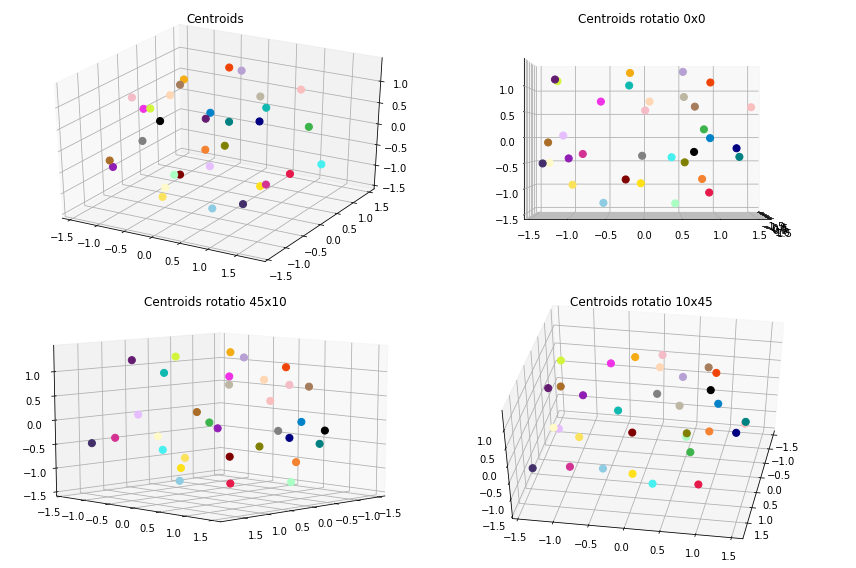

In [14]:
mds = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
)
X_cnt = mds.fit_transform(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

### Clusterização dos dados de Teste

Por fim, realizada a clusterização dos dados de teste e a apresentação das 8 primeiras frases do conjunto de teste juntamente com outras duas frases do cluster ao qual foi identificado como o melhor.

In [15]:
Xtest = X_test.to_numpy()
for i, xt in enumerate(XT[:8]):
    clt = kclusterer.classify(xt)
    print("*", Xtest[i])
    for frase in utils.shuffle(df[df["cluster"] == clt].to_numpy())[:2]:
        print("  - ", frase[0])
    print("-" * 20)

* Quanto da área total no meu país é coberta pela recepção?
  -  Quais são os preços para os planos de dados e chamadas diferentes que você oferece?
  -  Desde que não uso meus dados muito, posso mudar para um de plano apenas 1 GB de dados.
--------------------
* acesso ao meu email foi negado
  -  ok funcionou
  -  o email não esta no spam
--------------------
* voce nao conseguiu me ajudar, quero falar com um humano
  -  Preciso que um humano me ajude
  -  Qual é o processo para retornar o produto para uma loja?
--------------------
* voce nao sabe nada sobre vpn?
  -  Estou apenas olhando para ver quando eu posso mudar de telefone, obrigado pela sua ajuda.
  -  muitíssimo obrigado
--------------------
* Posso usar o meu telefone quando estou no exterior de férias e quais serão as tarifas?
  -  Que planos estão disponíveis para chamada e dados Internacional?
  -  Como atualizo minha conta para incluir chamadas internacionais?
--------------------
* Após quanto tempo do pagamento da f

### Métricas

Abaixo são apresentadas métricas para demonstrar o quanto a clusterização parece funcionar.

In [16]:
hom = homogeneity_score(y_test, [kclusterer.classify(xt) for xt in XT])
compl = completeness_score(y_test, [kclusterer.classify(xt) for xt in XT])
silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

print("Homogeneidade: ", np.round(hom, 3))
print("Completude   : ", np.round(compl, 3))
print("Silhouette   : ", np.round(silh, 3))

Homogeneidade:  0.685
Completude   :  0.702
Silhouette   :  -0.047


Como exemplo de comparação, foi executado o mesmo algoritmo de clusterização (conforme apresentado acima) entretanto variando a quantidade do número de clusters para verificar como as métricas se comportam.

In [17]:
t_cluster = 40

clusterizacao = []
for k in range(2, t_cluster):
    kclusterer = KMeansClusterer(k, distance=nltk.cluster.util.cosine_distance, repeats=20, avoid_empty_clusters=True)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
    assigned_clusters = np.array(assigned_clusters).ravel()
    centroids = kclusterer.means()
    
    hom = homogeneity_score(y_test, [kclusterer.classify(xt) for xt in XT])
    compl = completeness_score(y_test, [kclusterer.classify(xt) for xt in XT])
    silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

    clusterizacao.append({
        "Qtd. Cluster": k,
        "Homogeneity": np.round(hom, 3),
        "Completeness": np.round(compl, 3),
        "Silhouette": np.round(silh, 3),
    })

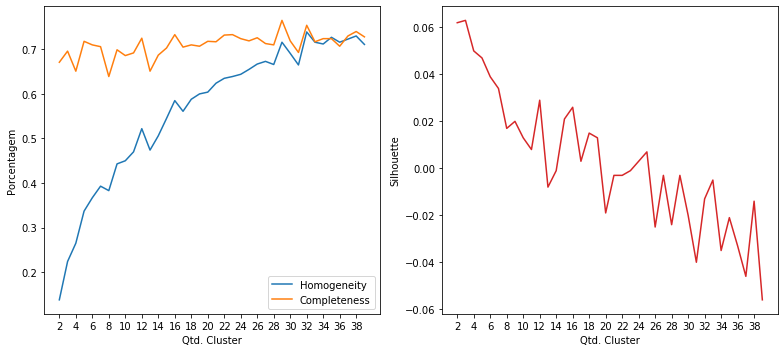

In [18]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Qtd. Cluster", "Homogeneity", "Completeness", "Silhouette"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Homogeneity"], label="Homogeneity")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Completeness"], label="Completeness")
plt.xticks(range(2, 40, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(2, 40, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()